In [1]:
import site
from pathlib import Path
site.addsitedir(str(Path.cwd().parents[2]))


import numpy as np
import torch
import matplotlib.pyplot as plt

from presentation.gherqin.config import DEVICE, DTYPE
from presentation.gherqin.neural_states.complex_rbm import ComplexWaveFunction
from presentation.gherqin.neural_states.pauli import create_dict
from presentation.gherqin.data.tomography import TomographyDataset, RBMTomographyLoader

In [2]:
train_path = "w_phase_meas_values.txt"
train_bases_path = "w_phase_meas_bases.txt"
psi_path = "w_phase_state.txt"
bases_path = "w_phase_unique_bases.txt"

torch.manual_seed(1234)

data = TomographyDataset(train_path, psi_path, train_bases_path, bases_path, device=DEVICE)

U = create_dict()
nv = data.num_visible()
nh = nv
nv, nh

(4, 4)

In [3]:
nn_state = ComplexWaveFunction(nv, nh, U, device=DEVICE)

epochs = 70
pos_batch_size = 100
neg_batch_size = pos_batch_size
lr = 1e-1
k = 10
log_every = 5

loader = RBMTomographyLoader(data, pos_batch_size, neg_batch_size, device=DEVICE, dtype=DTYPE)

space = nn_state.generate_hilbert_space()
history = nn_state.fit(
    loader,
    epochs=epochs,
    k=k,
    lr=lr,
    log_every=log_every,
    target=data.target(),
    bases=data.eval_bases(),
    space=space,
    print_metrics=True,
    metric_fmt="Epoch {ep}: Fidelity = {fid:.6f} | KL = {kl:.6f}",
)

history.keys()

Epoch 5: Fidelity = 0.031682 | KL = 0.524190
Epoch 10: Fidelity = 0.050014 | KL = 0.490603
Epoch 15: Fidelity = 0.043125 | KL = 0.472199
Epoch 20: Fidelity = 0.052150 | KL = 0.460279
Epoch 25: Fidelity = 0.052020 | KL = 0.449384
Epoch 30: Fidelity = 0.063698 | KL = 0.429596
Epoch 35: Fidelity = 0.075699 | KL = 0.409046
Epoch 40: Fidelity = 0.085834 | KL = 0.389351
Epoch 45: Fidelity = 0.331422 | KL = 0.322302
Epoch 50: Fidelity = 0.421965 | KL = 0.292134
Epoch 55: Fidelity = 0.690810 | KL = 0.227879
Epoch 60: Fidelity = 0.860432 | KL = 0.110306
Epoch 65: Fidelity = 0.906680 | KL = 0.075389
Epoch 70: Fidelity = 0.906868 | KL = 0.087577


dict_keys(['epoch', 'Fidelity', 'KL'])

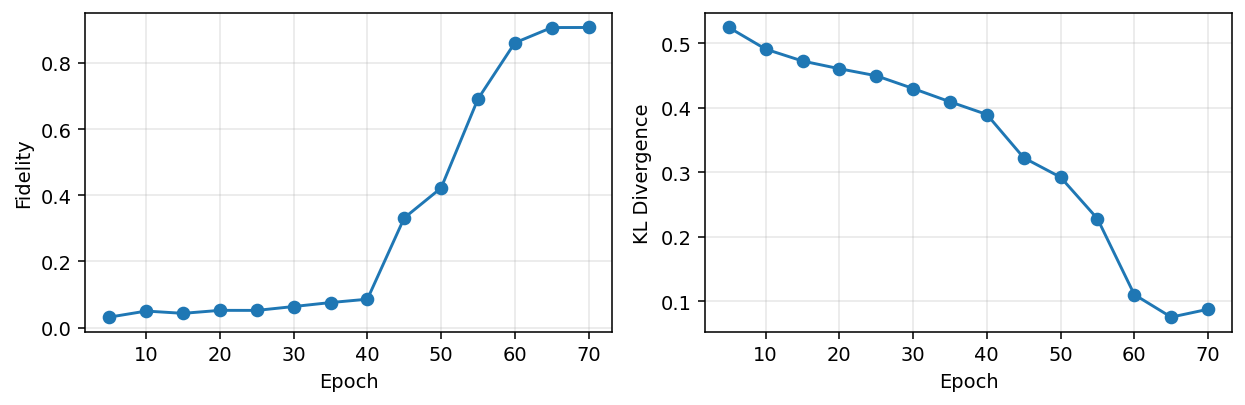

In [4]:
ep  = history.get("epoch", [])
fid = history.get("Fidelity", [])
kls = history.get("KL", [])

fig, axs = plt.subplots(1, 2, figsize=(9, 3.0), dpi=140)

axs[0].plot(ep, fid, 'o', linestyle="-")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Fidelity")

axs[1].plot(ep, kls, 'o', linestyle="-")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("KL Divergence")

for ax in axs: ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# One-hot indices: 1, 2, 4, ..., 2^(nv-1)
one_hot_indices = [1 << i for i in range(nv)]

# True phases from complex target (already complex in our dataset)
tgt = data.target().to(device=DEVICE, dtype=torch.cdouble)
true_phases_raw = torch.angle(tgt[one_hot_indices])
true_phases_wrapped = (true_phases_raw - true_phases_raw[0]) % (2 * np.pi)

# Predicted phases from model on the one-hot states
full_hilbert_space = nn_state.generate_hilbert_space()
one_hot_hilbert_space = full_hilbert_space[one_hot_indices, :]

pred_phases_raw = nn_state.phase(one_hot_hilbert_space)
pred_phases_wrapped = (pred_phases_raw - pred_phases_raw[0]) % (2 * np.pi)

true_phases_wrapped, pred_phases_wrapped

(tensor([0.0000, 6.2650, 4.9906, 3.2157], dtype=torch.float64),
 tensor([0.0000, 6.2804, 4.9891, 3.2598], dtype=torch.float64))

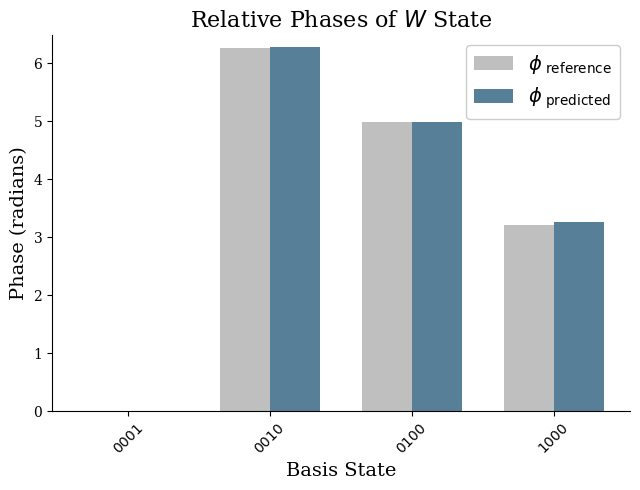

In [6]:
soft_gray = '#b0b0b0'
bdazzled_blue = '#2e5f7f'
plt.rcParams.update({"font.family": "serif"})

bitstrings = ["".join(str(int(b)) for b in row) for row in one_hot_hilbert_space.cpu().numpy()]
indices = np.arange(len(pred_phases_wrapped))
width = 0.35

fig, ax = plt.subplots(figsize=(6.5, 5), facecolor='white')
ax.set_facecolor('white')

# Bar plots
ax.bar(indices - width/2, true_phases_wrapped, width, alpha=0.8,
       color=soft_gray, label=r'$\phi_{\ \mathrm{reference}}$', zorder=1)
ax.bar(indices + width/2, pred_phases_wrapped, width, alpha=0.8,
       color=bdazzled_blue, label=r'$\phi_{\ \mathrm{predicted}}$', zorder=2)

# Labels and title
ax.set_xlabel("Basis State", fontsize=14)
ax.set_ylabel("Phase (radians)", fontsize=14)
ax.set_title(r"Relative Phases of $W$ State", fontsize=16)

ax.set_xticks(indices)
ax.set_xticklabels([f"${b}$" for b in bitstrings], rotation=45)

ax.set_ylim(0, 2 * np.pi + 0.2)

ax.legend(frameon=True, framealpha=1, loc='best', fontsize=14)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Layout and save
plt.tight_layout()
plt.savefig("phase_comparison_highres.png", dpi=300)
plt.show()